# Disposition Prediction Pipeline
This notebook creates a synthetic dataset for return dispositions, trains a Random Forest classifier, evaluates it, and saves a pipeline for inference.

Steps:
1. Generate synthetic data
2. EDA (basic)
3. Preprocessing pipeline (scaling + one-hot)
4. Train/test split and model training
5. Evaluation (classification report, confusion matrix)
6. Save trained pipeline
7. Example inference
8. Optional: SHAP explainability (if installed)


In [5]:
# Cell 2: imports & settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from uuid import uuid4
from collections import Counter

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# output paths
DATA_CSV = "synthetic_returns.csv"
MODEL_PATH = "rf_disposition_model.joblib"

print("Environment ready. Random state:", RANDOM_STATE)


Environment ready. Random state: 42


In [7]:
# Cell 3: synthetic data generator functions
import random
random.seed(RANDOM_STATE)

CATEGORIES = ['electronics','clothing','home','book','accessory']
REASONS = ['defective','not_as_described','size_issue','changed_mind','late_delivery']
INSPECTIONS = ['not_inspected','ok','damaged','missing_parts']
DISPOSITIONS = ['resell','refurbish','donate','recycle','returnless']

def sample_disposition(row):
    price = row['product_price']
    cat = row['product_category']
    reason = row['return_reason']
    inspection = row['inspection_status']
    fraud = row['fraud_score']
    
    # simple heuristics to generate correlated labels
    if fraud > 0.8:
        return np.random.choice(['returnless','recycle'], p=[0.7,0.3])
    if inspection == 'damaged' or reason == 'defective':
        return 'refurbish' if price > 150 else 'recycle'
    if cat == 'clothing' and reason == 'size_issue':
        return np.random.choice(['resell','donate'], p=[0.7,0.3])
    if reason == 'changed_mind' and price < 50:
        return 'returnless'
    if cat == 'electronics' and price > 200:
        return np.random.choice(['refurbish','resell'], p=[0.6,0.4])
    if cat == 'book':
        return 'resell'
    if price < 30:
        return 'donate'
    if price < 150:
        return np.random.choice(['resell','recycle'], p=[0.6,0.4])
    return 'refurbish'

def make_row():
    category = random.choice(CATEGORIES)
    # lognormal for positive skew — tweak per category
    mu = 5.8 if category=='electronics' else 4.5
    sigma = 0.7
    # sample price and ensure realistic ranges
    price = float(round(max(5.0, np.random.lognormal(mean=mu if category=='electronics' else 4.0, sigma=sigma)), 2))
    weight = float(round(max(0.01, np.random.normal(0.5 + (0.5 if category=='electronics' else 0.2), 0.4)), 3))
    reason = random.choice(REASONS)
    days = int(abs(np.random.exponential(scale=7)))
    distance = float(round(abs(np.random.normal(50, 30)), 2))
    cust_returns = int(np.random.poisson(0.3))
    order_ratio = float(round(np.random.uniform(0.5, 2.0), 2))
    fraud = float(round(min(1.0, max(0.0, np.random.beta(0.8, 8.0) + (0.5 if cust_returns>3 else 0.0))), 3))
    inspection = random.choices(INSPECTIONS, weights=[0.6,0.25,0.1,0.05])[0]
    prev_refurb = int(np.random.poisson(0.05))
    row = {
        'merchant_id': 'm_' + str(random.randint(1,20)),
        'order_id': str(uuid4()),
        'product_category': category,
        'product_price': price,
        'weight_kg': weight,
        'return_reason': reason,
        'days_since_purchase': days,
        'distance_km': distance,
        'customer_return_count_90d': cust_returns,
        'order_value_ratio': order_ratio,
        'fraud_score': fraud,
        'inspection_status': inspection,
        'previous_refurb_count': prev_refurb
    }
    row['disposition'] = sample_disposition(row)
    return row

def generate_dataset(n=8000, out_csv=DATA_CSV):
    rows = [make_row() for _ in range(n)]
    df = pd.DataFrame(rows)
    df.to_csv(out_csv, index=False)
    print(f"Generated {n} rows -> {out_csv}")
    return df


In [9]:
# Cell 4: generate and inspect
df = generate_dataset(8000)
df.head()


Generated 8000 rows -> synthetic_returns.csv


,merchant_id,order_id,product_category,product_price,weight_kg,return_reason,days_since_purchase,distance_km,customer_return_count_90d,order_value_ratio,fraud_score,inspection_status,previous_refurb_count,disposition
0,m_8,c3653fcc-24e0-4f8d-a5f1-182dc78542c7,electronics,467.64,0.945,defective,9,16.64,0,0.59,0.177,ok,0,refurbish
1,m_18,e648f3ac-67be-4355-bb60-5c196aefd3fc,clothing,36.36,0.490,not_as_described,1,57.26,0,0.94,0.173,ok,0,resell
2,m_1,fb5b2872-bdb3-4804-9c20-0bdf562c30c8,electronics,212.59,1.239,late_delivery,5,33.67,0,0.76,0.004,not_inspected,0,refurbish
3,m_20,bc215740-1147-4133-8a57-c6b91d5ac0a5,electronics,404.93,0.746,not_as_described,4,49.60,0,1.86,0.035,not_inspected,0,refurbish
4,m_18,b53947c3-9012-4773-af5a-f706264d517e,electronics,384.92,1.353,late_delivery,17,46.53,0,0.91,0.186,not_inspected,0,refurbish


In [11]:
# Cell 5: EDA
print("Shape:", df.shape)
print("\nDisposition class balance:")
print(df['disposition'].value_counts())
print("\nCategory x disposition cross-tab (normalized):")
display(pd.crosstab(df['product_category'], df['disposition'], normalize='index').round(3))

# Quick numeric summaries
display(df[['product_price','weight_kg','days_since_purchase','fraud_score']].describe().T)


Shape: (8000, 14)

Disposition class balance:
disposition
resell        2923
recycle       2528
refurbish     1484
returnless     541
donate         524
Name: count, dtype: int64

Category x disposition cross-tab (normalized):


disposition,donate,recycle,refurbish,resell,returnless
product_category,,,,,
accessory,0.096,0.445,0.081,0.297,0.081
book,0.000,0.253,0.022,0.646,0.080
clothing,0.116,0.389,0.065,0.336,0.093
electronics,0.000,0.067,0.678,0.255,0.000
home,0.119,0.434,0.071,0.290,0.086


,count,mean,std,min,25%,50%,75%,max
product_price,8000.0,143.875628,222.156111,5.00,39.115,68.675,144.25500,4364.360
weight_kg,8000.0,0.762170,0.407992,0.01,0.464,0.746,1.04025,2.420
days_since_purchase,8000.0,6.460375,6.850058,0.00,2.000,4.000,9.00000,59.000
fraud_score,8000.0,0.090260,0.091705,0.00,0.022,0.061,0.12800,0.713


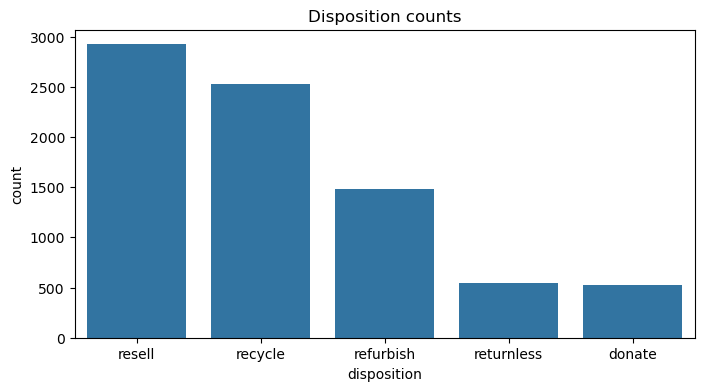

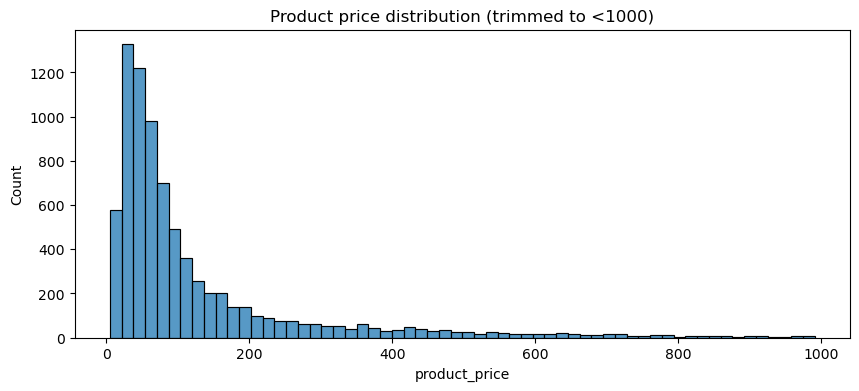

In [13]:
# Cell 6: visualizations
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='disposition', order=df['disposition'].value_counts().index)
plt.title("Disposition counts")
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(df.query("product_price<1000")['product_price'], bins=60)
plt.title("Product price distribution (trimmed to <1000)")
plt.show()

In [17]:
# Cell 7: preprocessing + model pipeline (fixed)
numeric_features = ['product_price','weight_kg','days_since_purchase','distance_km',
                    'customer_return_count_90d','order_value_ratio','fraud_score','previous_refurb_count']
categorical_features = ['product_category','return_reason','inspection_status']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', cat_transformer, categorical_features)
], remainder='drop')

clf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, class_weight='balanced')

pipe = Pipeline(steps=[('pre', preprocessor), ('clf', clf)])
print("Pipeline created successfully ✅")


Pipeline created successfully ✅


In [19]:
# Cell 8: train/test split and fit
X = df.drop(columns=['merchant_id','order_id','disposition'])
y = df['disposition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

print("Training pipeline (this may take a moment)...")
pipe.fit(X_train, y_train)
print("Training complete.")


Train size: (6400, 11) Test size: (1600, 11)
Training pipeline (this may take a moment)...
Training complete.


In [21]:
# Cell 9: classification report
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))


              precision    recall  f1-score   support

      donate     0.9565    0.8381    0.8934       105
     recycle     0.9053    0.6798    0.7765       506
   refurbish     0.8382    0.9596    0.8948       297
      resell     0.7206    0.8390    0.7753       584
  returnless     1.0000    1.0000    1.0000       108

    accuracy                         0.8219      1600
   macro avg     0.8841    0.8633    0.8680      1600
weighted avg     0.8352    0.8219    0.8208      1600



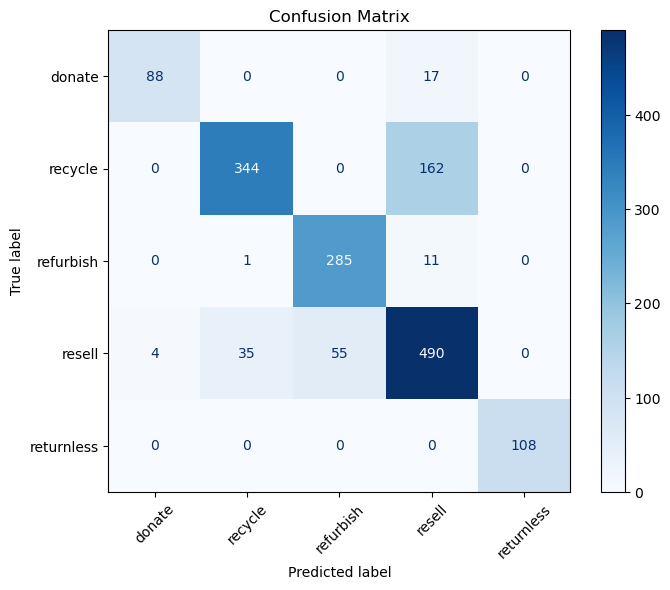

In [23]:
# Cell 10: confusion matrix visualization
cm = confusion_matrix(y_test, y_pred, labels=pipe.named_steps['clf'].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.named_steps['clf'].classes_)
fig, ax = plt.subplots(figsize=(8,6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [25]:
# Cell 11: approximate feature importance mapping
# Note: mapping exact one-hot feature names requires access to OneHotEncoder categories
# We'll extract feature names from transformer to display top importances

# get feature names after ColumnTransformer
def get_feature_names_from_column_transformer(ct):
    # numeric names
    num_names = numeric_features
    # cat names
    cat_names = []
    # fetch the onehot encoder categories
    try:
        ohe = ct.named_transformers_['cat'].named_steps['onehot']
        cats = ohe.categories_
        cat_cols = []
        cat_features = categorical_features
        for col, cats_i in zip(cat_features, cats):
            cat_cols.extend([f"{col}__{c}" for c in cats_i])
        return num_names + cat_cols
    except Exception as e:
        # fallback
        return num_names

feature_names = get_feature_names_from_column_transformer(preprocessor)
importances = pipe.named_steps['clf'].feature_importances_
# align lengths (in case of mismatch)
n = min(len(importances), len(feature_names))
feat_imp = pd.Series(importances[:n], index=feature_names[:n]).sort_values(ascending=False)
print("Top 15 feature importances:")
display(feat_imp.head(15))


Top 15 feature importances:


product_price                      0.348461
return_reason__changed_mind        0.133986
return_reason__defective           0.072859
product_category__electronics      0.063801
weight_kg                          0.040080
distance_km                        0.038239
fraud_score                        0.037620
order_value_ratio                  0.036931
inspection_status__damaged         0.036583
product_category__book             0.035610
days_since_purchase                0.028460
return_reason__size_issue          0.026959
return_reason__late_delivery       0.023337
return_reason__not_as_described    0.019766
product_category__clothing         0.012246
dtype: float64

In [27]:
# Cell 12: save pipeline
joblib.dump(pipe, MODEL_PATH)
print("Saved pipeline to", MODEL_PATH)


Saved pipeline to rf_disposition_model.joblib


In [29]:
# Cell 13: test a prediction
example = {
    "product_category":"electronics",
    "product_price":349.99,
    "weight_kg":1.2,
    "return_reason":"not_as_described",
    "days_since_purchase":4,
    "distance_km":120,
    "customer_return_count_90d":1,
    "order_value_ratio":1.1,
    "fraud_score":0.05,
    "inspection_status":"not_inspected",
    "previous_refurb_count":0
}

# prepare dataframe
ex_df = pd.DataFrame([example])
proba = pipe.predict_proba(ex_df)[0]
pred = pipe.predict(ex_df)[0]
classes = pipe.named_steps['clf'].classes_
prob_dict = dict(zip(classes, proba))
print("Predicted disposition:", pred)
print("Confidence:", float(proba.max()))
print("Probabilities:", {k:round(float(v),4) for k,v in prob_dict.items()})


Predicted disposition: refurbish
Confidence: 0.62
Probabilities: {'donate': 0.0, 'recycle': 0.01, 'refurbish': 0.62, 'resell': 0.37, 'returnless': 0.0}


In [31]:
# === Many curated test cases to probe the disposition model ===
# Run this cell after training so `pipe` is available.
import pandas as pd
import numpy as np
from IPython.display import display

# Each case: fields should match your model EXPECTED_COLUMNS.
test_cases = [
    # 1. High-value electronics, not inspected -> likely refurbish/resell
    {"id":"tc01","product_category":"electronics","product_price":1200.0,"weight_kg":1.5,
     "return_reason":"not_as_described","days_since_purchase":3,"distance_km":200,
     "customer_return_count_90d":0,"order_value_ratio":1.2,"fraud_score":0.02,
     "inspection_status":"not_inspected","previous_refurb_count":0,
     "expected":"refurbish","rationale":"High price electronics -> refurbish or resell."},

    # 2. Low-price changed-mind -> likely returnless (refund)
    {"id":"tc02","product_category":"accessory","product_price":12.0,"weight_kg":0.05,
     "return_reason":"changed_mind","days_since_purchase":2,"distance_km":10,
     "customer_return_count_90d":0,"order_value_ratio":0.8,"fraud_score":0.01,
     "inspection_status":"not_inspected","previous_refurb_count":0,
     "expected":"returnless","rationale":"Low price, changed mind -> returnless is economical."},

    # 3. Clothing size issue, moderate price -> resell/donate
    {"id":"tc03","product_category":"clothing","product_price":45.0,"weight_kg":0.25,
     "return_reason":"size_issue","days_since_purchase":5,"distance_km":25,
     "customer_return_count_90d":1,"order_value_ratio":1.0,"fraud_score":0.05,
     "inspection_status":"not_inspected","previous_refurb_count":0,
     "expected":"resell","rationale":"Size issue in clothing -> resell or donate."},

    # 4. Defective electronics, inspected as damaged, high price -> refurbish or recycle
    {"id":"tc04","product_category":"electronics","product_price":350.0,"weight_kg":0.9,
     "return_reason":"defective","days_since_purchase":10,"distance_km":80,
     "customer_return_count_90d":0,"order_value_ratio":1.0,"fraud_score":0.02,
     "inspection_status":"damaged","previous_refurb_count":0,
     "expected":"refurbish","rationale":"Defective but high value -> refurbish if feasible."},

    # 5. Fragile low-value item, damaged -> recycle
    {"id":"tc05","product_category":"home","product_price":18.0,"weight_kg":0.4,
     "return_reason":"defective","days_since_purchase":8,"distance_km":40,
     "customer_return_count_90d":0,"order_value_ratio":0.9,"fraud_score":0.01,
     "inspection_status":"damaged","previous_refurb_count":0,
     "expected":"recycle","rationale":"Low value and damaged -> recycle."},

    # 6. Book, slight defect -> resell
    {"id":"tc06","product_category":"book","product_price":9.99,"weight_kg":0.3,
     "return_reason":"not_as_described","days_since_purchase":4,"distance_km":20,
     "customer_return_count_90d":0,"order_value_ratio":0.6,"fraud_score":0.02,
     "inspection_status":"ok","previous_refurb_count":0,
     "expected":"resell","rationale":"Books usually resell easily."},

    # 7. High fraud score -> returnless
    {"id":"tc07","product_category":"electronics","product_price":220.0,"weight_kg":0.8,
     "return_reason":"changed_mind","days_since_purchase":2,"distance_km":60,
     "customer_return_count_90d":5,"order_value_ratio":3.0,"fraud_score":0.95,
     "inspection_status":"not_inspected","previous_refurb_count":2,
     "expected":"returnless","rationale":"High fraud probability -> refund without return."},

    # 8. Accessory, missing parts (inspection) -> recycle or returnless depending on price
    {"id":"tc08","product_category":"accessory","product_price":25.0,"weight_kg":0.12,
     "return_reason":"not_as_described","days_since_purchase":6,"distance_km":15,
     "customer_return_count_90d":0,"order_value_ratio":0.9,"fraud_score":0.05,
     "inspection_status":"missing_parts","previous_refurb_count":0,
     "expected":"recycle","rationale":"Missing parts reduce resellability."},

    # 9. Repeated-return customer, medium-value item -> cautious (donate/recycle or returnless)
    {"id":"tc09","product_category":"home","product_price":90.0,"weight_kg":1.2,
     "return_reason":"not_as_described","days_since_purchase":3,"distance_km":30,
     "customer_return_count_90d":4,"order_value_ratio":1.5,"fraud_score":0.4,
     "inspection_status":"not_inspected","previous_refurb_count":1,
     "expected":"recycle","rationale":"High return frequency may suggest stricter disposition."},

    # 10. Very long since purchase -> less likely resell (maybe recycle)
    {"id":"tc10","product_category":"electronics","product_price":150.0,"weight_kg":0.7,
     "return_reason":"not_as_described","days_since_purchase":120,"distance_km":50,
     "customer_return_count_90d":0,"order_value_ratio":0.8,"fraud_score":0.05,
     "inspection_status":"not_inspected","previous_refurb_count":0,
     "expected":"recycle","rationale":"Old purchases degrade resell value."},

    # 11. High price clothing (designer) -> refurbish/resell
    {"id":"tc11","product_category":"clothing","product_price":450.0,"weight_kg":0.6,
     "return_reason":"changed_mind","days_since_purchase":2,"distance_km":10,
     "customer_return_count_90d":0,"order_value_ratio":1.5,"fraud_score":0.02,
     "inspection_status":"not_inspected","previous_refurb_count":0,
     "expected":"resell","rationale":"High-value clothing could be resold."},

    # 12. Small cheap accessory with 0 weight (edge) -> returnless
    {"id":"tc12","product_category":"accessory","product_price":3.5,"weight_kg":0.0,
     "return_reason":"changed_mind","days_since_purchase":1,"distance_km":5,
     "customer_return_count_90d":0,"order_value_ratio":0.5,"fraud_score":0.01,
     "inspection_status":"not_inspected","previous_refurb_count":0,
     "expected":"returnless","rationale":"Tiny/cheap items -> refund cheaper than shipping back."},

    # 13. Unseen category (OOD) -> model should still output something reasonable
    {"id":"tc13","product_category":"gadget_xyz","product_price":80.0,"weight_kg":0.5,
     "return_reason":"not_as_described","days_since_purchase":3,"distance_km":40,
     "customer_return_count_90d":0,"order_value_ratio":1.0,"fraud_score":0.05,
     "inspection_status":"not_inspected","previous_refurb_count":0,
     "expected":"refurbish","rationale":"Mid-value electronics-like gadget -> refurbish/resell."},

    # 14. Donation-friendly item (low price, good condition, clothing) -> donate
    {"id":"tc14","product_category":"clothing","product_price":20.0,"weight_kg":0.3,
     "return_reason":"changed_mind","days_since_purchase":3,"distance_km":15,
     "customer_return_count_90d":0,"order_value_ratio":0.7,"fraud_score":0.03,
     "inspection_status":"ok","previous_refurb_count":0,
     "expected":"donate","rationale":"Low price clothing can be donated easily."},

    # 15. Previous refurb heavy product type -> refurbish again
    {"id":"tc15","product_category":"electronics","product_price":260.0,"weight_kg":1.0,
     "return_reason":"defective","days_since_purchase":7,"distance_km":60,
     "customer_return_count_90d":0,"order_value_ratio":1.2,"fraud_score":0.03,
     "inspection_status":"ok","previous_refurb_count":3,
     "expected":"refurbish","rationale":"History suggests product is refurbishable."},

    # 16. Heavy bulky item with low resale value -> recycle
    {"id":"tc16","product_category":"home","product_price":35.0,"weight_kg":8.0,
     "return_reason":"changed_mind","days_since_purchase":4,"distance_km":100,
     "customer_return_count_90d":0,"order_value_ratio":0.9,"fraud_score":0.02,
     "inspection_status":"not_inspected","previous_refurb_count":0,
     "expected":"recycle","rationale":"High shipping cost makes returns uneconomic."},

    # 17. Short time since purchase, warranty-eligible -> refurbish
    {"id":"tc17","product_category":"electronics","product_price":180.0,"weight_kg":0.7,
     "return_reason":"defective","days_since_purchase":5,"distance_km":20,
     "customer_return_count_90d":0,"order_value_ratio":1.0,"fraud_score":0.02,
     "inspection_status":"not_inspected","previous_refurb_count":0,
     "expected":"refurbish","rationale":"Recent defective -> eligible for refurbishment."},

    # 18. Customer with many returns, low-price item -> returnless to avoid cost
    {"id":"tc18","product_category":"accessory","product_price":18.0,"weight_kg":0.1,
     "return_reason":"changed_mind","days_since_purchase":2,"distance_km":10,
     "customer_return_count_90d":6,"order_value_ratio":0.8,"fraud_score":0.3,
     "inspection_status":"not_inspected","previous_refurb_count":0,
     "expected":"returnless","rationale":"Repeat returner + low price -> refund."},

    # 19. Late delivery complaint for medium priced electronics -> resell/refurbish
    {"id":"tc19","product_category":"electronics","product_price":280.0,"weight_kg":1.1,
     "return_reason":"late_delivery","days_since_purchase":9,"distance_km":120,
     "customer_return_count_90d":0,"order_value_ratio":1.0,"fraud_score":0.02,
     "inspection_status":"ok","previous_refurb_count":0,
     "expected":"resell","rationale":"Product likely fine; resell preferred."},

    # 20. Very high distance (international) -> returnless
    {"id":"tc20","product_category":"home","product_price":80.0,"weight_kg":3.0,
     "return_reason":"not_as_described","days_since_purchase":6,"distance_km":2000,
     "customer_return_count_90d":0,"order_value_ratio":1.0,"fraud_score":0.04,
     "inspection_status":"not_inspected","previous_refurb_count":0,
     "expected":"returnless","rationale":"International shipping cost too high."},

    # 21. Missing parts but high price -> refurbish if possible
    {"id":"tc21","product_category":"electronics","product_price":700.0,"weight_kg":2.0,
     "return_reason":"not_as_described","days_since_purchase":4,"distance_km":60,
     "customer_return_count_90d":0,"order_value_ratio":1.2,"fraud_score":0.05,
     "inspection_status":"missing_parts","previous_refurb_count":0,
     "expected":"refurbish","rationale":"High price favors refurbishment even if parts missing."},

    # 22. Edge case: negative days_since_purchase (bad data) -> treat as recent
    {"id":"tc22","product_category":"accessory","product_price":22.0,"weight_kg":0.15,
     "return_reason":"not_as_described","days_since_purchase":-3,"distance_km":10,
     "customer_return_count_90d":0,"order_value_ratio":1.0,"fraud_score":0.02,
     "inspection_status":"not_inspected","previous_refurb_count":0,
     "expected":"resell","rationale":"Treat negative as recent; resell likely."},

    # 23. Zero price (gift/complimentary) -> donate or returnless
    {"id":"tc23","product_category":"accessory","product_price":0.0,"weight_kg":0.05,
     "return_reason":"changed_mind","days_since_purchase":2,"distance_km":5,
     "customer_return_count_90d":0,"order_value_ratio":0.0,"fraud_score":0.01,
     "inspection_status":"not_inspected","previous_refurb_count":0,
     "expected":"donate","rationale":"Zero price item -> donation preferable."},

    # 24. Very large previous_refurb_count -> avoid refurbish if failing, maybe recycle
    {"id":"tc24","product_category":"electronics","product_price":150.0,"weight_kg":0.8,
     "return_reason":"defective","days_since_purchase":6,"distance_km":50,
     "customer_return_count_90d":0,"order_value_ratio":1.0,"fraud_score":0.02,
     "inspection_status":"damaged","previous_refurb_count":10,
     "expected":"recycle","rationale":"Many previous refurb attempts -> recycle."
    },
]

# Convert into DataFrame preserving ID and expected labels
df_tests = pd.DataFrame(test_cases)
df_inputs = df_tests[[c for c in df_tests.columns if c not in ('id','expected','rationale')]].copy()
df_inputs.index = df_tests['id']

# If some unexpected columns are present/absent, ensure pipeline's expected columns are present:
EXPECTED_COLUMNS = ['product_category','product_price','weight_kg','return_reason','days_since_purchase',
                    'distance_km','customer_return_count_90d','order_value_ratio','fraud_score','inspection_status','previous_refurb_count']
for col in EXPECTED_COLUMNS:
    if col not in df_inputs.columns:
        # fill with sensible defaults
        defaults = {
            'product_category':'accessory','product_price':50.0,'weight_kg':0.2,'return_reason':'changed_mind',
            'days_since_purchase':5,'distance_km':30,'customer_return_count_90d':0,'order_value_ratio':1.0,
            'fraud_score':0.1,'inspection_status':'not_inspected','previous_refurb_count':0
        }
        df_inputs[col] = defaults[col]

# Run predictions
preds = pipe.predict(df_inputs[EXPECTED_COLUMNS])
probs = pipe.predict_proba(df_inputs[EXPECTED_COLUMNS])
classes = pipe.named_steps['clf'].classes_

# Build results DataFrame
results = []
for i, idx in enumerate(df_inputs.index):
    pred = preds[i]
    prob = probs[i].max()
    prob_dist = {classes[j]: float(probs[i,j]) for j in range(len(classes))}
    expected = df_tests.loc[df_tests['id']==idx, 'expected'].values[0]
    rationale = df_tests.loc[df_tests['id']==idx, 'rationale'].values[0]
    results.append({
        'id': idx,
        'predicted': pred,
        'confidence': round(float(prob),4),
        'expected': expected,
        'match': (pred == expected),
        'rationale': rationale,
        'probabilities': prob_dist
    })

df_results = pd.DataFrame(results).set_index('id')
display(df_results[['predicted','confidence','expected','match']])

# Print mismatches with rationale & full probabilities for inspection
mismatches = df_results[df_results['match']==False]
print(f"\nMismatches: {len(mismatches)}")
if len(mismatches)>0:
    for idx,row in mismatches.iterrows():
        print("\n---", idx, "---")
        print("Expected:", row['expected'])
        print("Predicted:", row['predicted'], " (conf:", row['confidence'],")")
        print("Rationale:", row['rationale'])
        print("Probabilities:", {k:round(v,3) for k,v in row['probabilities'].items()})
else:
    print("All test cases matched expected heuristics!")

# Optionally, show the full probs table (first few rows)
display(pd.DataFrame([r['probabilities'] for r in results], index=df_results.index).round(3).head(12))


,predicted,confidence,expected,match
id,,,,
tc01,refurbish,0.510,refurbish,True
tc02,returnless,0.950,returnless,True
tc03,resell,0.685,resell,True
tc04,refurbish,0.970,refurbish,True
tc05,recycle,0.990,recycle,True
tc06,resell,0.920,resell,True
tc07,resell,0.525,returnless,False
tc08,donate,0.810,recycle,False
tc09,resell,0.590,recycle,False



Mismatches: 13

--- tc07 ---
Expected: returnless
Predicted: resell  (conf: 0.525 )
Rationale: High fraud probability -> refund without return.
Probabilities: {'donate': 0.005, 'recycle': 0.065, 'refurbish': 0.405, 'resell': 0.525, 'returnless': 0.0}

--- tc08 ---
Expected: recycle
Predicted: donate  (conf: 0.81 )
Rationale: Missing parts reduce resellability.
Probabilities: {'donate': 0.81, 'recycle': 0.055, 'refurbish': 0.005, 'resell': 0.13, 'returnless': 0.0}

--- tc09 ---
Expected: recycle
Predicted: resell  (conf: 0.59 )
Rationale: High return frequency may suggest stricter disposition.
Probabilities: {'donate': 0.02, 'recycle': 0.375, 'refurbish': 0.015, 'resell': 0.59, 'returnless': 0.0}

--- tc10 ---
Expected: recycle
Predicted: refurbish  (conf: 0.57 )
Rationale: Old purchases degrade resell value.
Probabilities: {'donate': 0.0, 'recycle': 0.115, 'refurbish': 0.57, 'resell': 0.315, 'returnless': 0.0}

--- tc11 ---
Expected: resell
Predicted: refurbish  (conf: 0.69 )
Rational

,donate,recycle,refurbish,resell,returnless
id,,,,,
tc01,0.000,0.005,0.510,0.485,0.000
tc02,0.010,0.005,0.000,0.035,0.950
tc03,0.290,0.020,0.005,0.685,0.000
tc04,0.000,0.020,0.970,0.010,0.000
tc05,0.010,0.990,0.000,0.000,0.000
tc06,0.045,0.030,0.000,0.920,0.005
tc07,0.005,0.065,0.405,0.525,0.000
tc08,0.810,0.055,0.005,0.130,0.000
tc09,0.020,0.375,0.015,0.590,0.000


In [33]:
import pandas as pd
import numpy as np

# Simulated orders history (this would come from your DB)
orders = pd.DataFrame([
    {"customer_id":"c001","order_id":"o101","product_price":150,"purchase_date":"2025-10-01"},
    {"customer_id":"c001","order_id":"o102","product_price":80,"purchase_date":"2025-10-15"},
    {"customer_id":"c001","order_id":"o103","product_price":200,"purchase_date":"2025-11-01"},
    {"customer_id":"c002","order_id":"o104","product_price":50,"purchase_date":"2025-09-20"},
    {"customer_id":"c002","order_id":"o105","product_price":55,"purchase_date":"2025-10-25"},
    {"customer_id":"c003","order_id":"o106","product_price":600,"purchase_date":"2025-09-10"},
])

# Simulated returns table (new return event)
returns = pd.DataFrame([
    {"customer_id":"c001","order_id":"o103","return_reason":"not_as_described","days_since_purchase":5},
    {"customer_id":"c002","order_id":"o105","return_reason":"changed_mind","days_since_purchase":2},
    {"customer_id":"c003","order_id":"o106","return_reason":"defective","days_since_purchase":20}
])


In [35]:
# Step 1: compute average order value per customer
avg_values = orders.groupby('customer_id')['product_price'].mean().rename('avg_order_value')

# Step 2: merge with orders to compute ratio
orders = orders.merge(avg_values, on='customer_id', how='left')
orders['order_value_ratio'] = orders['product_price'] / orders['avg_order_value']

display(orders)


,customer_id,order_id,product_price,purchase_date,avg_order_value,order_value_ratio
0,c001,o101,150,2025-10-01,143.333333,1.046512
1,c001,o102,80,2025-10-15,143.333333,0.558140
2,c001,o103,200,2025-11-01,143.333333,1.395349
3,c002,o104,50,2025-09-20,52.500000,0.952381
4,c002,o105,55,2025-10-25,52.500000,1.047619
5,c003,o106,600,2025-09-10,600.000000,1.000000


In [37]:
def compute_fraud_score(row):
    score = 0.0
    
    # more than 3 returns in 90 days
    if row.get('customer_return_count_90d', 0) > 3:
        score += 0.3
    # very high order_value_ratio (spent way more than usual)
    if row.get('order_value_ratio', 1.0) > 2.5:
        score += 0.3
    # very low days_since_purchase (quick return)
    if row.get('days_since_purchase', 0) <= 3:
        score += 0.2
    # high product price might indicate incentive for abuse
    if row.get('product_price', 0) > 500:
        score += 0.2
    
    # bound to [0,1]
    return round(min(1.0, score), 3)


In [39]:
# merge returns with order info
returns = returns.merge(orders[['order_id','product_price','order_value_ratio']], on='order_id', how='left')

# simulate customer_return_count_90d (for demo)
returns['customer_return_count_90d'] = [2,4,1]

# compute fraud score
returns['fraud_score'] = returns.apply(compute_fraud_score, axis=1)
display(returns[['order_id','product_price','order_value_ratio','customer_return_count_90d','days_since_purchase','fraud_score']])


,order_id,product_price,order_value_ratio,customer_return_count_90d,days_since_purchase,fraud_score
0,o103,200,1.395349,2,5,0.0
1,o105,55,1.047619,4,2,0.5
2,o106,600,1.000000,1,20,0.2


In [41]:
returns['inspection_status'] = 'not_inspected'


In [43]:
# Example updates later
inspection_updates = {
    'o103': 'ok',
    'o105': 'missing_parts',
    'o106': 'damaged'
}
returns['inspection_status'] = returns['order_id'].map(inspection_updates).fillna('not_inspected')


In [45]:
final = returns.copy()
final['product_category'] = ['electronics','accessory','electronics']
final['weight_kg'] = [1.2,0.1,1.5]
final['distance_km'] = [120,15,40]
final['previous_refurb_count'] = [0,0,1]

display(final[['order_id','product_price','order_value_ratio','fraud_score','inspection_status']])

,order_id,product_price,order_value_ratio,fraud_score,inspection_status
0,o103,200,1.395349,0.0,ok
1,o105,55,1.047619,0.5,missing_parts
2,o106,600,1.000000,0.2,damaged
